### Importando as bibliotecas necessarias

In [1]:
import os
import pandas as pd

import numpy as np
import tensorflow as tf

import tensorflow_recommenders as tfrs

In [2]:
anime_syn = pd.read_csv('anime_with_synopsis.csv')
animelist = pd.read_csv('animelist.csv', nrows=1000000)
ws = pd.read_csv('watching_status.csv')
anime_list = pd.read_csv('anime.csv')

### Data Exploration and Visualization
Aqui utilizaremos duas fontes de dados:

*anime_with_synopsis.csv* - Contém o id, nome, score, genero e sinopse de todos os animes.

*animelist* - Contém user_id, anime_id, watching_status, watched_episodes

A base de dados contém 16214 animes.

In [3]:
print(anime_syn.shape)
anime_syn.head()

(16214, 5)


,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


A base de dados completa contém mais de 100 milhões de interações de usuarios, mas para esse teste eu utilizarei somente 10000 interações pra entendermos como o modelo se comporta com poucos dados.

In [4]:
ws

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


Pegamos uma amostra aleatoria de usuarios contendo diferentes quantidades de interações, para ver como o modelo se comporta em cada caso

### Data Preprocessing
Aqui será unificado a tabela de sinopses com a tabela de interações ja que precisa ser fornecido somente uma tabela para o modelo.
Tambem será filtrado somente as colunas que serão usadas para treino.

In [5]:

interactions = animelist.merge(anime_syn, left_on='anime_id',right_on='MAL_ID')
dataset = interactions[["user_id","anime_id","Name","sypnopsis","Genres"]].sample(frac=1).iloc[:100000]

In [6]:
dataset.user_id.value_counts()

781     408
890     369
1397    316
3160    314
1469    298
       ... 
2128      1
1768      1
2292      1
3161      1
2467      1
Name: user_id, Length: 3006, dtype: int64

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(dataset.astype(str).to_dict(orient='list'))
animes_data = tf.data.Dataset.from_tensor_slices(anime_syn.astype(str).to_dict(orient='list'))

In [8]:
unique_anime_titles = np.unique(list(animes_data.map(lambda x: x["MAL_ID"]).as_numpy_iterator()))
unique_user_ids = np.unique(list(dataset.map(lambda x: x["user_id"]).as_numpy_iterator()))

In [9]:
print(f"Quantidade de animes na no dataset: {len(unique_anime_titles)}")
print(f"Quantidade de usuarios na no dataset: {len(unique_user_ids)}")

Quantidade de animes na no dataset: 16214
Quantidade de usuarios na no dataset: 3006


In [10]:
animes = animes_data.map(lambda x: {
    "anime_id": x["MAL_ID"],
    "sypnopsis": x["sypnopsis"],
    "names": x["Name"],
    "genres": x["Genres"]
})

### Modeling

In [11]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

  def call(self, inputs):
    return self.user_embedding(inputs["user_id"])

In [12]:
class QueryModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.embedding_model = UserModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [13]:
class AnimeModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000
  # Uma camada de pré-processamento que mapeia recursos de string para índices inteiros.
    self.anime_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_anime_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_titles) + 1, 32)
    ])

  # Vectorização e embedding das sinopses dos animes
    self.syp_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.syp_text_embedding = tf.keras.Sequential([
      self.syp_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 512, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.syp_vectorizer.adapt(animes.map(lambda x: x["sypnopsis"]))

    # Vectorização e embedding dos generos dos animes
    self.genre_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)
    
    self.genre_text_embedding = tf.keras.Sequential([
      self.genre_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.genre_vectorizer.adapt(animes.map(lambda x: x["genres"]))
  # Vectorização e embedding dos titulos de animes
    self.name_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)
    
    self.name_text_embedding = tf.keras.Sequential([
      self.name_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.name_vectorizer.adapt(animes.map(lambda x: x["names"]))

  def call(self, input):
    return tf.concat([
      self.anime_embedding(input["anime_id"]),
      self.syp_text_embedding(input["sypnopsis"]),
      self.genre_text_embedding(input["genres"]),
      self.name_text_embedding(input["names"])
      ],axis=1)
        

In [14]:
class CandidateModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.embedding_model = AnimeModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [15]:
class AnimelensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=animes.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "user_id":features["user_id"]
    })
    anime_embeddings = self.candidate_model({
        "anime_id":features["anime_id"],
        "sypnopsis":features["sypnopsis"],
        "genres":features["Genres"],
        "names": features["Name"]
      })

    return self.task(
        query_embeddings, anime_embeddings, compute_metrics=not training)

In [16]:
shuffled = dataset.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

In [17]:
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [18]:
num_epochs = 20

model = AnimelensModel([128])

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [20]:
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

In [23]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 35s 7s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 6.0000e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0021 - factorized_top_k/top_50_categorical_accuracy: 0.0199 - factorized_top_k/top_100_categorical_accuracy: 0.0461 - loss: 37530.7331 - regularization_loss: 0.0000e+00 - total_loss: 37530.7331


{'factorized_top_k/top_1_categorical_accuracy': 4.999999873689376e-05,
 'factorized_top_k/top_5_categorical_accuracy': 0.0006000000284984708,
 'factorized_top_k/top_10_categorical_accuracy': 0.002050000010058284,
 'factorized_top_k/top_50_categorical_accuracy': 0.019899999722838402,
 'factorized_top_k/top_100_categorical_accuracy': 0.04610000178217888,
 'loss': 34120.8515625,
 'regularization_loss': 0,
 'total_loss': 34120.8515625}

In [24]:
one_layer_history.history.keys()

dict_keys(['factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss', 'val_factorized_top_k/top_1_categorical_accuracy', 'val_factorized_top_k/top_5_categorical_accuracy', 'val_factorized_top_k/top_10_categorical_accuracy', 'val_factorized_top_k/top_50_categorical_accuracy', 'val_factorized_top_k/top_100_categorical_accuracy', 'val_loss', 'val_regularization_loss', 'val_total_loss'])

In [25]:
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")
print(f"Validation Loss: {np.mean(one_layer_history.history['val_total_loss'])}")

Top-100 accuracy: 0.05.
Validation Loss: 31999.90087890625


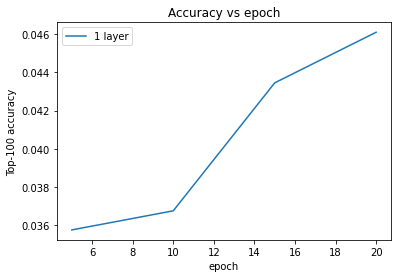

In [26]:
import matplotlib.pyplot as plt
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch") 
plt.ylabel("Top-100 accuracy")
plt.legend()

### Test
Pegamos primeiro um usuario com poucas interações e testamos como a recomendação desempenha.

Primeiro vamos considerar somente o conteúdo que ele viu, podemos ver que tem atributos como:

*rating* -  um target explicito do quanto ele gostou do anime.

*watching_status* - um atributo que diz se ele abandonou, continua assistindo ou ja assistiu.

*watched_episodes* - quantidade de episódios assistidos.

Isso são atributos que poderiam ser considerados na hora do preprocessamento para melhorar a acuracia do modelo, por exemplo, poderiamos remover os animes que ele abandonou ou deu nota menor que 5.


In [27]:
interactions.user_id.value_counts()[:]

781     3927
890     3619
1397    3070
3021    2927
1469    2894
        ... 
2282       1
92         1
2834       1
1126       1
1510       1
Name: user_id, Length: 3128, dtype: int64

### Recomendação utilizando BruteForce

In [28]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k=50)
index.index_from_dataset(
    tf.data.Dataset.zip((animes.batch(128).map(lambda x: x["anime_id"]), animes.batch(128).map(model.candidate_model)))
)

In [29]:
#using bruteforce to recomend}
def make_recomendations(index,user_id):
    animes_s = interactions.loc[interactions.user_id == user_id,'MAL_ID'].astype(str).values
    if len(animes_s):
        scores, titles = index.query_with_exclusions(
            queries={'user_id':tf.constant([str(user_id)])},
            exclusions=tf.constant([animes_s]),
            k=50)
    else:
        scores, titles = index(
            queries={'user_id':tf.constant([user_id])},
        )

    print(f"Recomendações para o usuario {user_id}: {np.unique(titles[0])}")
    return np.unique(titles[0])

Leva 0.5 segundos para recomendar 50 animes para o usuario.

In [30]:
titles = make_recomendations(index,2997)

Recomendações para o usuario 2997: [b'10378' b'1059' b'10807' b'1103' b'1172' b'11889' b'15313' b'1583'
 b'16774' b'20359' b'20655' b'20939' b'2163' b'2166' b'21809' b'24701'
 b'293' b'30300' b'30694' b'32866' b'329' b'33756' b'35298' b'35330'
 b'36023' b'37033' b'37046' b'38490' b'40358' b'40506' b'413' b'4719'
 b'5118' b'5141' b'5220' b'602' b'603' b'6129' b'6609' b'6634' b'7048'
 b'707' b'7619' b'8068' b'900' b'902' b'903' b'905' b'914' b'9515']


### Recomendação utilizando Streaming

In [31]:
index_st = tfrs.layers.factorized_top_k.Streaming(model.query_model)
index_st.index_from_dataset(
    tf.data.Dataset.zip((animes.batch(128).map(lambda x: x["anime_id"]), animes.batch(128).map(model.candidate_model)))
)

Leva 4.2 segundos para recomendar 50 animes para o usuario.

In [32]:
titles_2 = make_recomendations(index_st, 2997)

Recomendações para o usuario 2997: [b'10378' b'1059' b'10807' b'1103' b'1172' b'11889' b'15313' b'1583'
 b'16774' b'20359' b'20655' b'20939' b'2163' b'2166' b'21809' b'24701'
 b'293' b'30300' b'30694' b'32866' b'329' b'33756' b'35298' b'35330'
 b'36023' b'37033' b'37046' b'38490' b'40358' b'40506' b'413' b'4719'
 b'5118' b'5141' b'5220' b'602' b'603' b'6129' b'6609' b'6634' b'7048'
 b'707' b'7619' b'8068' b'900' b'902' b'903' b'905' b'914' b'9515']


In [33]:
%%time
recomendations = {"Name":[], "Genres":[],"Score":[]}
for title in np.unique(titles):
    recomendations["Name"].append(anime_list.loc[anime_list.MAL_ID == int(title.decode('utf-8')),'Name'].values[0])
    recomendations["Genres"].append(anime_list.loc[anime_list.MAL_ID == int(title.decode('utf-8')),'Genres'].values[0])
    recomendations["Score"].append(anime_list.loc[anime_list.MAL_ID == int(title.decode('utf-8')),'Score'].values[0])

Wall time: 52.8 ms


Animes ja visto pelo usuario

In [34]:
interactions.loc[interactions.user_id ==2997]

,user_id,anime_id,rating,watching_status,watched_episodes,MAL_ID,Name,Score,Genres,sypnopsis
1649,2997,6702,7,1,16,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...","In the mystical land of Fiore, magic exists as..."
2937,2997,4898,10,2,24,4898,Kuroshitsuji,7.75,"Action, Mystery, Comedy, Historical, Demons, S...","Young Ciel Phantomhive is known as ""the Queen'..."
4232,2997,21,10,1,608,21,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...","Gol D. Roger was known as the ""Pirate King,"" t..."
4935,2997,24,0,6,0,24,School Rumble,7.94,"Comedy, Romance, School, Shounen","Just the words ""I love you,"" and everything ch..."
6204,2997,6098,0,6,0,6098,Sora no Manimani,7.09,"Slice of Life, Comedy, Romance, School, Seinen",Saku Ooyagi returns to his hometown after seve...
...,...,...,...,...,...,...,...,...,...,...
969952,2997,9523,6,2,1,9523,Minori Scramble!,6.24,Comedy,Tamaki is an elementary school girl. Her fathe...
972654,2997,11069,8,2,1,11069,Pokemon: Pikachu no Fushigi na Fushigi na Daib...,6.33,"Adventure, Comedy, Fantasy, Kids","hile being let out to play by their trainers, ..."
972693,2997,10917,9,2,2,10917,Pokemon: Pikachu no Fuyuyasumi (2001),6.41,"Adventure, Comedy, Fantasy, Kids",Pikachu's Winter Vacations are three series of...
973040,2997,2044,0,6,0,2044,Mahou no Tenshi Creamy Mami,7.13,"Comedy, Fantasy, Magic, Romance, School, Sci-F...","Creamy Mami is about a young girl, Yuu, who af..."


Recomendações

In [35]:
r = pd.DataFrame(recomendations)    
r

,Name,Genres,Score
0,Shinryaku!? Ika Musume,"Comedy, Shounen, Slice of Life",7.51
1,Mutant Turtles: Choujin Densetsu-hen,"Action, Adventure, Comedy, Sci-Fi, Super Power",5.27
2,Nichijou: Original Jikai Yokoku,"Slice of Life, Comedy, School",7.0
3,Shinkon Gattai Godannar!!,"Ecchi, Comedy, Mecha, Romance, Sci-Fi",6.69
4,Slayers Try,"Adventure, Comedy, Demons, Magic, Fantasy, Sho...",7.83
5,The iDOLM@STER: 765 Pro to Iu Monogatari,"Music, Comedy, Drama",7.47
6,Wooser no Sono Higurashi,"Slice of Life, Comedy, Fantasy",6.23
7,009-1,"Action, Mecha, Sci-Fi, Seinen",6.26
8,Inferno Cop,"Action, Comedy, Police",7.28
9,Yamada-kun to 7-nin no Majo,"Comedy, School, Shounen, Supernatural",7.3


In [36]:
genres_recomended = []
for x in r.Genres.str.split(', '):
    genres_recomended +=x
print(f"Categorias dos animes recomendados: {sorted(np.unique(genres_recomended))}")

Categorias dos animes recomendados: ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural']


In [37]:
genres_watched = []
for x in interactions[interactions.user_id==2997].Genres.str.split(', '):
    genres_watched += x
print(f"Categorias dos animes assistidos: {sorted(np.unique(genres_watched))}") 

Categorias dos animes assistidos: ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire']


### Anime Embeddings

In [40]:
ds = tf.data.Dataset.from_tensor_slices(anime_syn[["Name","MAL_ID","sypnopsis","Genres"]].astype(str).to_dict(orient='list'))

In [41]:
anime_names = []
anime_embeddings = []
for i,x in enumerate(ds):
  anime_names.append(x["Name"].numpy())
  anime_embeddings.append(
      model.candidate_model(
    {
    'anime_id': np.array([x["MAL_ID"].numpy().decode('utf-8')]),
    'sypnopsis': np.array([x["sypnopsis"].numpy().decode('utf-8')]),
    'genres': np.array([x["Genres"].numpy().decode('utf-8')]),
    'names': np.array([x["Name"].numpy().decode('utf-8')])
})[0])
  if i ==200:
    break


In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
item_tsne = TSNE(n_components=3,perplexity=30).fit_transform(anime_embeddings)

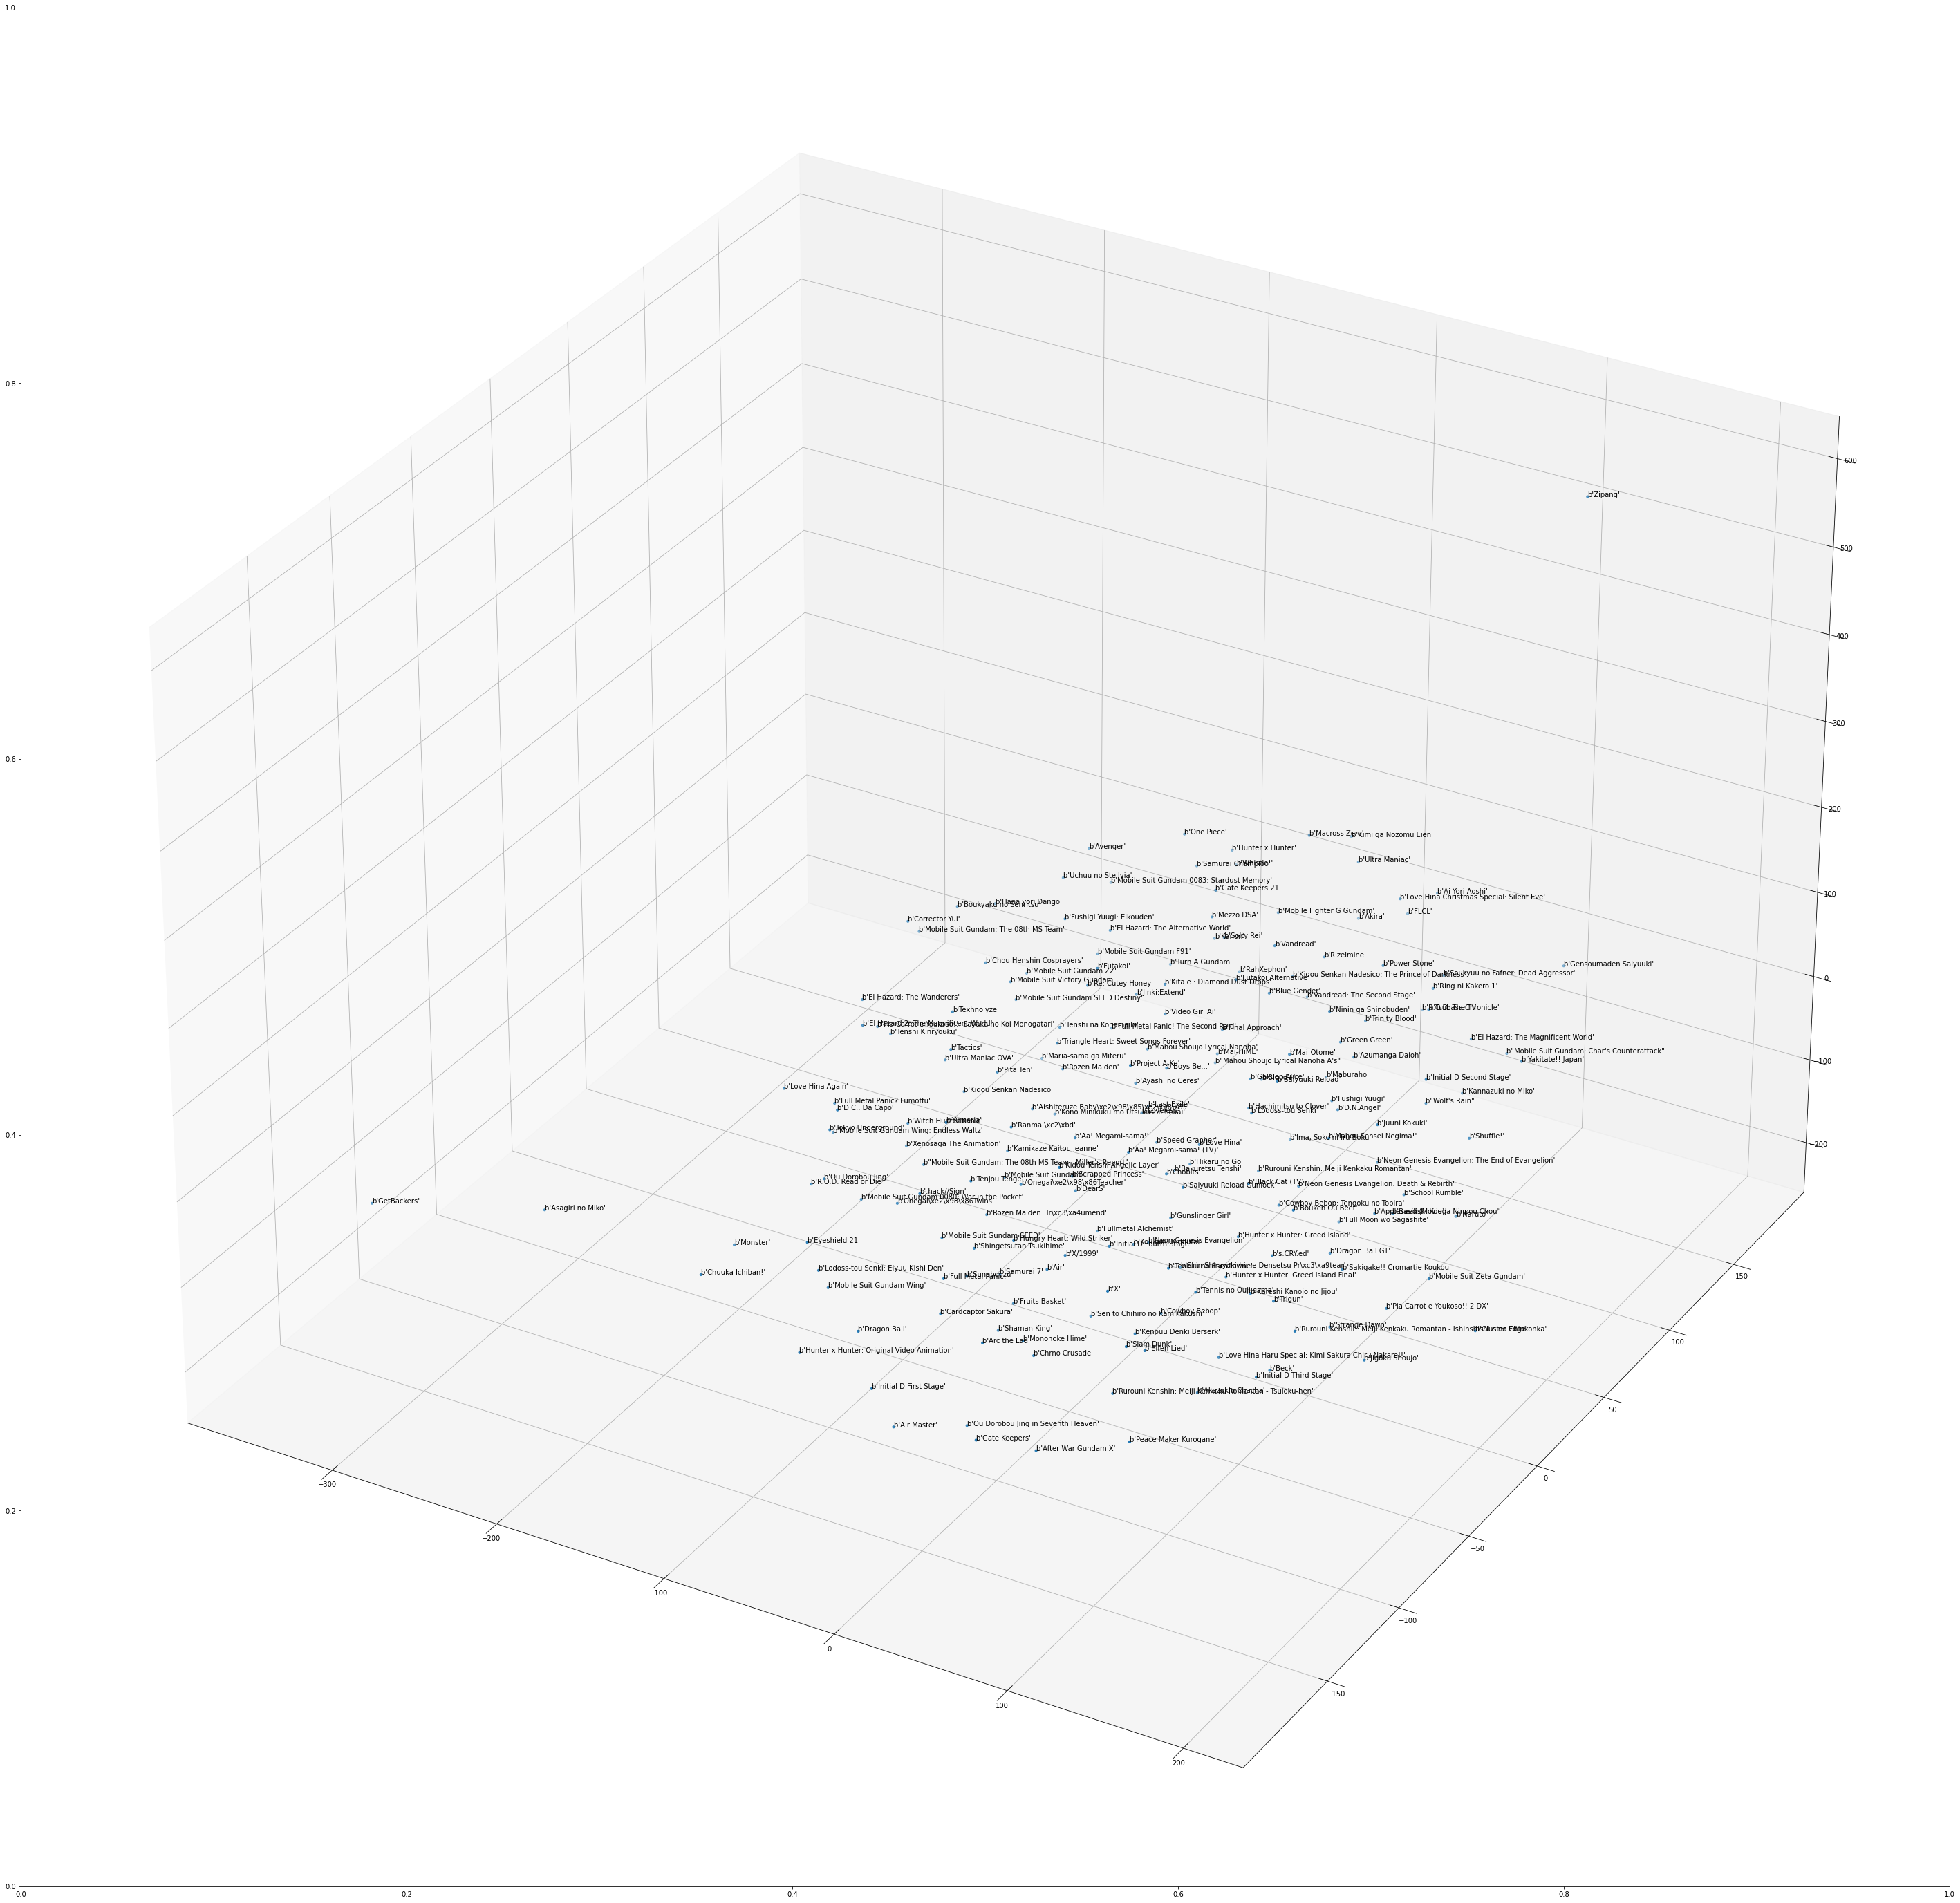

In [43]:
fig, ax = plt.subplots(figsize=(50,50))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(item_tsne[:,0], item_tsne[:,1], item_tsne[:,2], s=10)

for i, txt in enumerate(anime_names):
    ax.text(item_tsne[i,0],item_tsne[i,1],item_tsne[i,2],txt)
fig.savefig('embeddings_3.png')